In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import numpy as np
from io import StringIO

# ==============================================================================
# PHẦN 1: CHUẨN BỊ DỮ LIỆU LỚN (ĐỌC FILE CỦA BẠN)
# ==============================================================================
FILE_PATH = r'D:\GIS_Project\data\6_DSCanhKQ2_CanTho_XoaCon3Cot_XoaDongTrung.txt'

print(f"--- 1. ĐANG NẠP DỮ LIỆU TỪ: {FILE_PATH} ---")
try:
    df = pd.read_csv(FILE_PATH, sep='\t')
    df.columns = df.columns.str.strip()
    if 'IdStar' in df.columns: df.rename(columns={'IdStar': 'IdStart'}, inplace=True)
    
    G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')
    for u, v in G.edges(): G[u][v]['weight'] = G[u][v]['Length']
    
    # Tạo layout (Cho dữ liệu lớn, k nhỏ để gom cụm tốt hơn)
    print("   -> Đang tính toán layout (có thể mất vài giây)...")
    pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50) 
    
    all_points = list(G.nodes())
    print(f"   -> Hoàn tất: {len(all_points)} đỉnh, {G.number_of_edges()} cạnh.")

except Exception as e:
    print(f"[LỖI] {e}")
    # (Dùng dữ liệu mẫu nếu lỗi để demo không bị crash)
    G = nx.grid_2d_graph(10, 10); pos = nx.spring_layout(G)
    all_points = list(G.nodes())

--- 1. ĐANG NẠP DỮ LIỆU TỪ: D:\GIS_Project\data\6_DSCanhKQ2_CanTho_XoaCon3Cot_XoaDongTrung.txt ---
   -> Đang tính toán layout (có thể mất vài giây)...
   -> Hoàn tất: 2434 đỉnh, 2925 cạnh.


In [2]:
# ==============================================================================
# PHẦN 2: THUẬT TOÁN TÍNH MẬT ĐỘ (TỐI ƯU TỐC ĐỘ)
# ==============================================================================
def get_neighbors_count_fast(G, start_node, eps):
    # Dijkstra cục bộ chỉ để đếm số lượng
    distances = {start_node: 0}
    queue = [(0, start_node)]
    count = 0
    
    while queue:
        d, u = heapq.heappop(queue)
        if d > eps: continue
        
        count += 1
        
        for v in G.neighbors(u):
            w = G[u][v]['weight'] # Dùng weight đã chuẩn hóa
            new_d = d + w
            if new_d <= eps:
                if new_d < distances.get(v, float('inf')):
                    distances[v] = new_d
                    heapq.heappush(queue, (new_d, v))
    return count - 1

In [5]:
# ==============================================================================
# PHẦN 3: TRỰC QUAN HÓA THÔNG MINH (SMART VISUALIZATION)
# ==============================================================================
def visualize_algo2_density_large_data(G, points, eps, pos):
    print(f"\n--- ĐANG TÍNH MẬT ĐỘ CHO TOÀN BỘ {len(points)} ĐIỂM (EPS={eps}) ---")
    print("(Quá trình này sẽ chạy Dijkstra 2600 lần, vui lòng đợi...)")
    
    # 1. Tính mật độ
    density_map = {}
    for i, p in enumerate(points):
        # In tiến độ mỗi 500 điểm
        if i % 500 == 0: print(f"   -> Đã xử lý {i}/{len(points)} điểm...")
        density_map[p] = get_neighbors_count_fast(G, p, eps)
        
    print("   -> Hoàn tất tính toán.")

    # 2. Sắp xếp
    sorted_points = sorted(density_map.items(), key=lambda item: item[1], reverse=True)
    
    # 3. VẼ BIỂU ĐỒ CỘT (CHỈ VẼ TOP 50 CAO NHẤT + 50 THẤP NHẤT ĐỂ THẤY DÁNG)
    # Hoặc vẽ mẫu (sampling) nếu muốn thấy toàn cảnh
    plt.figure(figsize=(14, 6))
    
    # Lấy mẫu: Cứ 10 điểm lấy 1 điểm để vẽ cho đỡ dày đặc
    # Hoặc lấy Top 100 điểm cao nhất để xem đỉnh đồi
    top_n = 100
    display_data = sorted_points[:top_n]
    
    ids = [str(item[0]) for item in display_data]
    densities = [item[1] for item in display_data]
    
    bars = plt.bar(range(len(densities)), densities, color='#1f77b4', width=1.0)
    
    # Tô màu Cam cho vùng Lõi (Ví dụ MinPts = 5)
    MIN_PTS_DEMO = 20
    for i, val in enumerate(densities):
        if val >= MIN_PTS_DEMO:
            bars[i].set_color('#ff7f0e') # Cam
    
    plt.axhline(y=MIN_PTS_DEMO, color='red', linestyle='--', label=f'MinPts={MIN_PTS_DEMO}')
    
    plt.xlabel(f'Top {top_n} Điểm có Mật độ cao nhất (Đã sắp xếp)', fontsize=12)
    plt.ylabel('Mật độ', fontsize=12)
    plt.title(f'BIỂU ĐỒ SẮP XẾP MẬT ĐỘ (TOP {top_n} CAO NHẤT)\nCác cột màu Cam là ứng viên cho Trung tâm Cụm', fontsize=14)
    plt.legend()
    plt.show()
    
    # 4. VẼ BẢN ĐỒ NHIỆT (HEATMAP) TOÀN CẢNH
    print("--- ĐANG VẼ BẢN ĐỒ NHIỆT (HEATMAP) ---")
    plt.figure(figsize=(15, 12))
    
    # Vẽ nền mờ (các cạnh)
    # alpha nhỏ để không che mất node
    nx.draw_networkx_edges(G, pos, edge_color='#DDDDDD', width=0.5, alpha=0.5)
    
    # Chuẩn bị màu
    node_colors = [density_map[n] for n in G.nodes()]
    
    # Vẽ Node (Kích thước nhỏ s=20 để không bị chồng chéo quá mức)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=30, 
                                   node_color=node_colors, 
                                   cmap=plt.cm.jet, # Jet: Xanh(thấp) -> Đỏ(cao)
                                   alpha=0.8)
    
    plt.colorbar(nodes, label='Mật độ (Số hàng xóm)')
    plt.title(f'BẢN ĐỒ NHIỆT MẬT ĐỘ TP. CẦN THƠ (Eps={eps})\n(Đỏ rực = Khu vực sầm uất, Xanh dương = Khu vực thưa thớt)', fontsize=15)
    plt.axis('off')
    plt.show()


--- ĐANG TÍNH MẬT ĐỘ CHO TOÀN BỘ 2434 ĐIỂM (EPS=200.0) ---
(Quá trình này sẽ chạy Dijkstra 2600 lần, vui lòng đợi...)
   -> Đã xử lý 0/2434 điểm...
   -> Đã xử lý 500/2434 điểm...
   -> Đã xử lý 1000/2434 điểm...
   -> Đã xử lý 1500/2434 điểm...
   -> Đã xử lý 2000/2434 điểm...
   -> Hoàn tất tính toán.


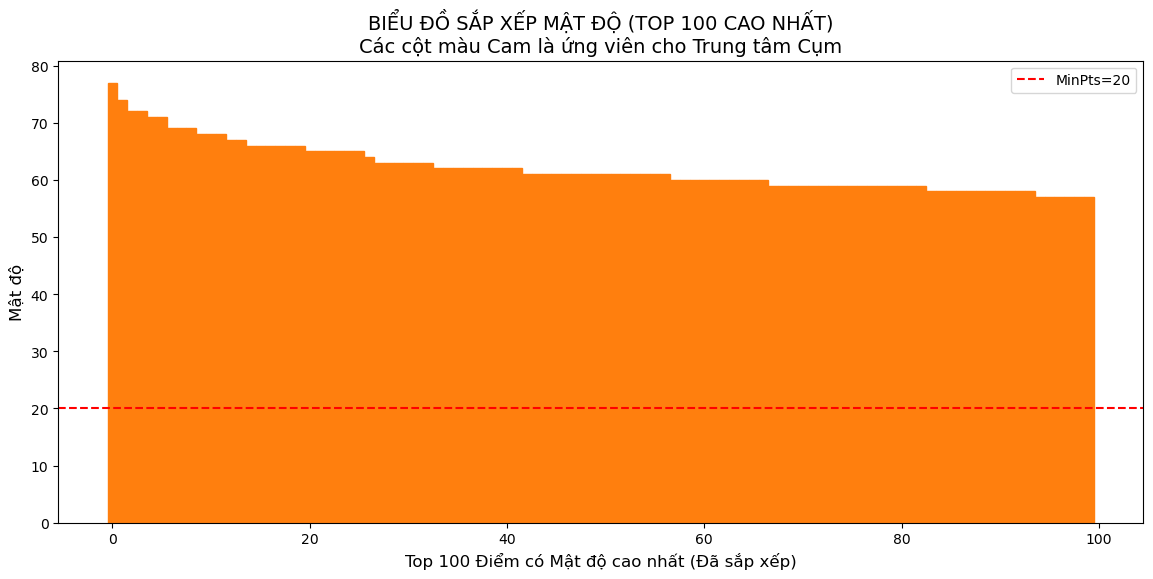

--- ĐANG VẼ BẢN ĐỒ NHIỆT (HEATMAP) ---


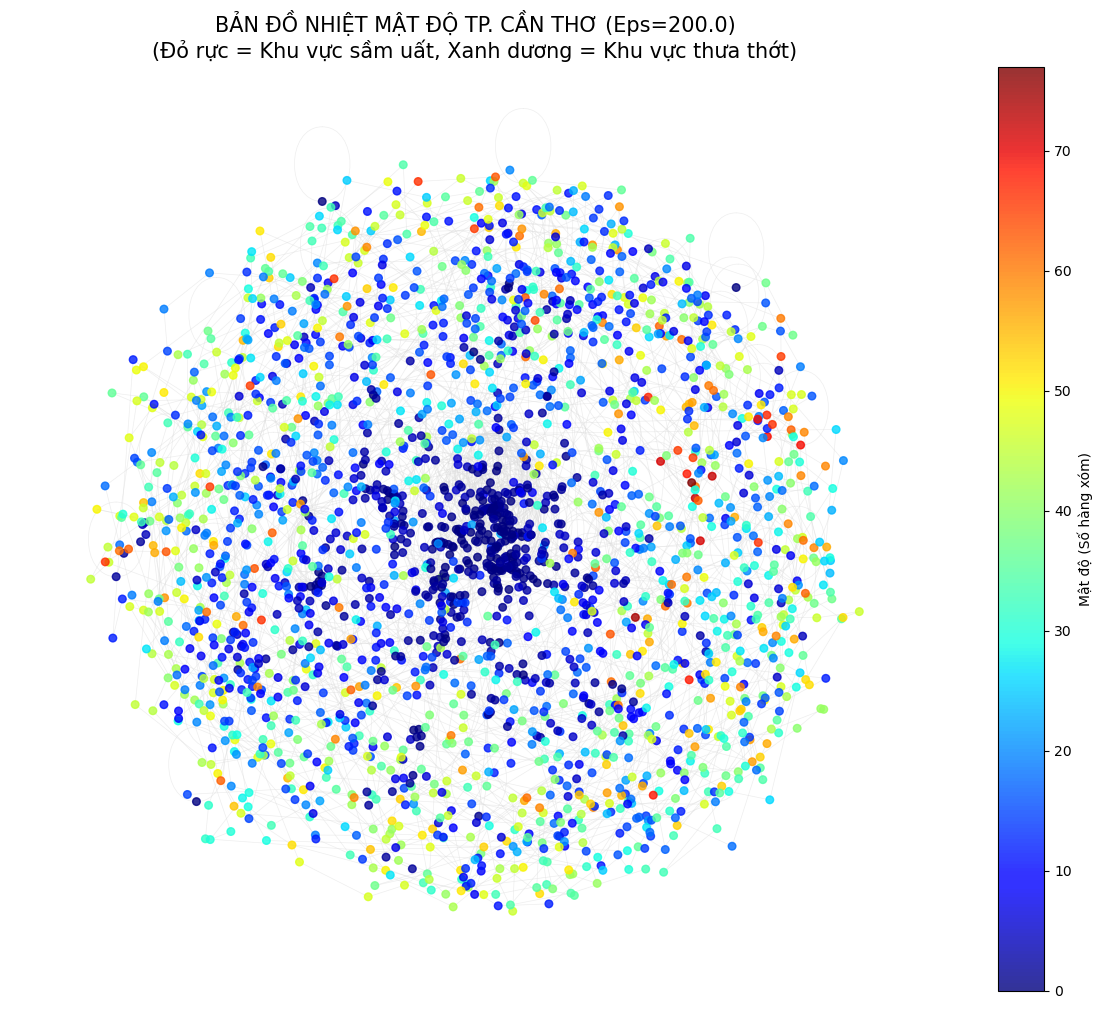

In [6]:
# ==============================================================================
# PHẦN 4: CHẠY THỬ (CẤU HÌNH THAM SỐ THỰC TẾ)
# ==============================================================================

# Với dữ liệu Cần Thơ (đơn vị mét?), Eps có thể là 100m, 200m
EPS_REAL = 200.0

visualize_algo2_density_large_data(G, all_points, eps=EPS_REAL, pos=pos)